In [1]:
import glob
import rioxarray as rxr
import pandas as pd
import numpy as np
import xarray as xr
import os
import geopandas as gpd
import netCDF4
from datetime import datetime
import time
import rasterio
import matplotlib.pyplot as plt

In [2]:
starting_value = 0
name = 'BUDD'
model = 'M1'
year = 2022
ps_sca_dir = f'/home/etboud/projects/data/temp/{name}/{model}/'
ps_sca_tif = glob.glob(ps_sca_dir + f'*{year}*.tif')

In [3]:
rgi = '/home/etboud/projects/data/RGI/02_rgi60_WesternCanadaUS/02_rgi60_WesternCanadaUS.shp'
rgi_mask = gpd.read_file(rgi).to_crs('EPSG:32611')
wbd = '/home/etboud/projects/data/masks/NHDWaterbody.shp'
wbd_mask = gpd.read_file(wbd).to_crs('EPSG:32611')

BS = f'/home/etboud/projects/data/basins/{name}/{name}_4326.geojson'
basin = gpd.read_file(BS)
basin = basin.to_crs('EPSG:32611') 


### Stacking tifs

In [4]:
# Load the reference GeoTIFF
with rasterio.open('/home/etboud/projects/data/masks/BUDD_mask.tif') as ref:
    ref_crs = ref.crs
    ref_transform = ref.transform
    ref_width = ref.width
    ref_height = ref.height

In [ ]:
from shapely.ops import unary_union
# Step 1: Build the mask only once
valid_area = unary_union(basin.geometry.values)
invalid_area = unary_union(rgi_mask.geometry.values.tolist() + wbd_mask.geometry.values.tolist())



from affine import Affine
import numpy as np
import xarray as xr
import rioxarray
from datetime import datetime

# Step 1: Build your data stack (clipped_data should be the same size as BUDD_mask)
dates_list = []
data_list = []

for file in sorted(ps_sca_tif):
    date = np.datetime64(datetime.strptime(os.path.basename(file).split('_')[0], '%Y%m%d'))
    dates_list.append(date)

    data = rxr.open_rasterio(file, drop=True, chunks = True, masked=True).squeeze('band', drop=True)
    data = data.fillna(0)
    data = data.rio.clip([final_geometry], basin.crs)
    # Optional: assert shape matches reference
    assert data.shape == (ref_height, ref_width), f"Shape mismatch: {data.shape}"

    data_list.append(data.values)  # get raw values for stacking

# Step 2: Stack the data
stacked_data = np.stack(data_list, axis=0).astype(float)

# Step 3: Generate real-world coordinate arrays from ref_transform
x_coords = np.arange(ref_width) * ref_transform.a + ref_transform.c
y_coords = np.arange(ref_height) * ref_transform.e + ref_transform.f
if ref_transform.e < 0:
    y_coords = y_coords[::-1]

# Step 4: Build the DataArray with real coordinates
xr_data = xr.DataArray(
    stacked_data,
    dims=['time', 'y', 'x'],
    coords={'time': dates_list, 'y': y_coords, 'x': x_coords}
)

# Step 5: Assign CRS and transform directly
xr_data = xr_data.rio.write_crs(ref_crs)
xr_data = xr_data.rio.write_transform(ref_transform)
xr_data.name = "data"
# Step 6: Save to NetCDF
xr_data.to_netcdf(f'/home/etboud/projects/data/stacks/{name}_{model}_{year}_projected.nc', format='NETCDF4')

### testing stack

In [5]:

def create_fsca_df(dataset):
    sca_df = []
    for t in range(len(dataset.time)):
        slice = dataset['data'].isel(time=t)
        fsca = (np.nansum(slice) / np.count_nonzero(~np.isnan(slice)))*100
        sca_df.append(fsca)    
    #create dataframe with fsca_list and corresponding dates
    dates = pd.to_datetime(dataset.time.values)
    df = pd.DataFrame({'date': dates, 'fsca': sca_df})
    return df

In [30]:
# m1 = xr.open_dataset(f'/home/etboud/projects/data/stacks/BUDD_M1_2022.nc')
# m1_pp = xr.open_dataset(f'/home/etboud/projects/data/stacks/BUDD_M1PP_2022_3_50_NDVI_QAQC.nc')
# m1_pp_t = xr.open_dataset(f'/home/etboud/projects/data/stacks/BUDD_M1PP_2022_NDVI_QAQC_temporal.nc')
# test = xr.open_dataset('/home/etboud/projects/data/stacks/BUDD_M1_2022_projected.nc')
temp = xr.open_dataset('/home/etboud/projects/data/stacks/BUDD_M1PP_2022_3_50_NDVI_QAQC.nc')

In [16]:
temp

<xarray.Dataset> Size: 24MB
Dimensions:      (time: 2, y: 1627, x: 914)
Coordinates:
  * time         (time) datetime64[ns] 16B 2022-03-26 2022-03-27
  * y            (y) float64 13kB 4.195e+06 4.195e+06 ... 4.19e+06 4.19e+06
  * x            (x) float64 7kB 2.883e+05 2.883e+05 ... 2.91e+05 2.91e+05
Data variables:
    spatial_ref  int64 8B ...
    data         (time, y, x) float64 24MB ...

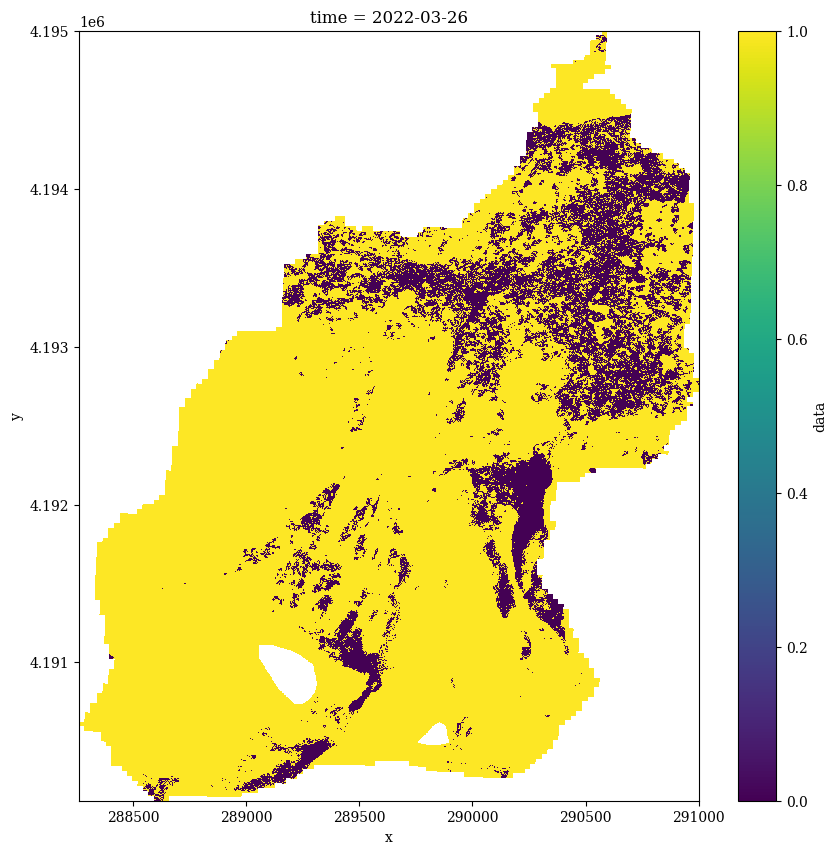

In [31]:
# plot first time slice of temp data
fig,ax = plt.subplots(figsize=(10, 10))
temp['data'].isel(time=0).plot(ax=ax, cmap='viridis', vmin=0, vmax=1)

In [19]:
# m1_df = create_fsca_df(m1)
# m1_pp_df = create_fsca_df(m1_pp)
# m1_pp_t_df = create_fsca_df(m1_pp_t)
# test_df = create_fsca_df(test)
temp_df = create_fsca_df(temp)

In [21]:
temp_df

,date,fsca
0,2022-03-26,100.0
1,2022-03-27,100.0


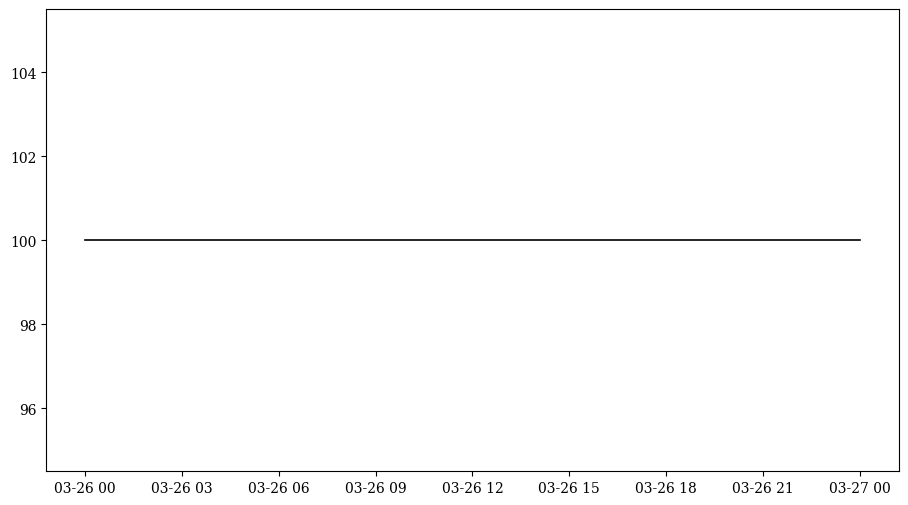

In [20]:
# plot the timeseries 
fig, ax = plt.subplots(figsize=(11, 6))
plt.rcParams['font.family'] = 'serif'
# ax.plot(m1_df['date'], m1_df['fsca'], color='crimson', linewidth=1.2)
# ax.plot(m1_pp_df['date'], m1_pp_df['fsca'], color='darkorange', linewidth=1.2)
# ax.plot(m1_pp_t_df['date'], m1_pp_t_df['fsca'], color='royalblue', linewidth=1.2)
# ax.plot(test_df['date'], test_df['fsca'], color='darkgreen', linewidth=1.2)
ax.plot(temp_df['date'], temp_df['fsca'], color='black', linewidth=1.2)
